## **Vision Transformer**
*By Cristian Leo*

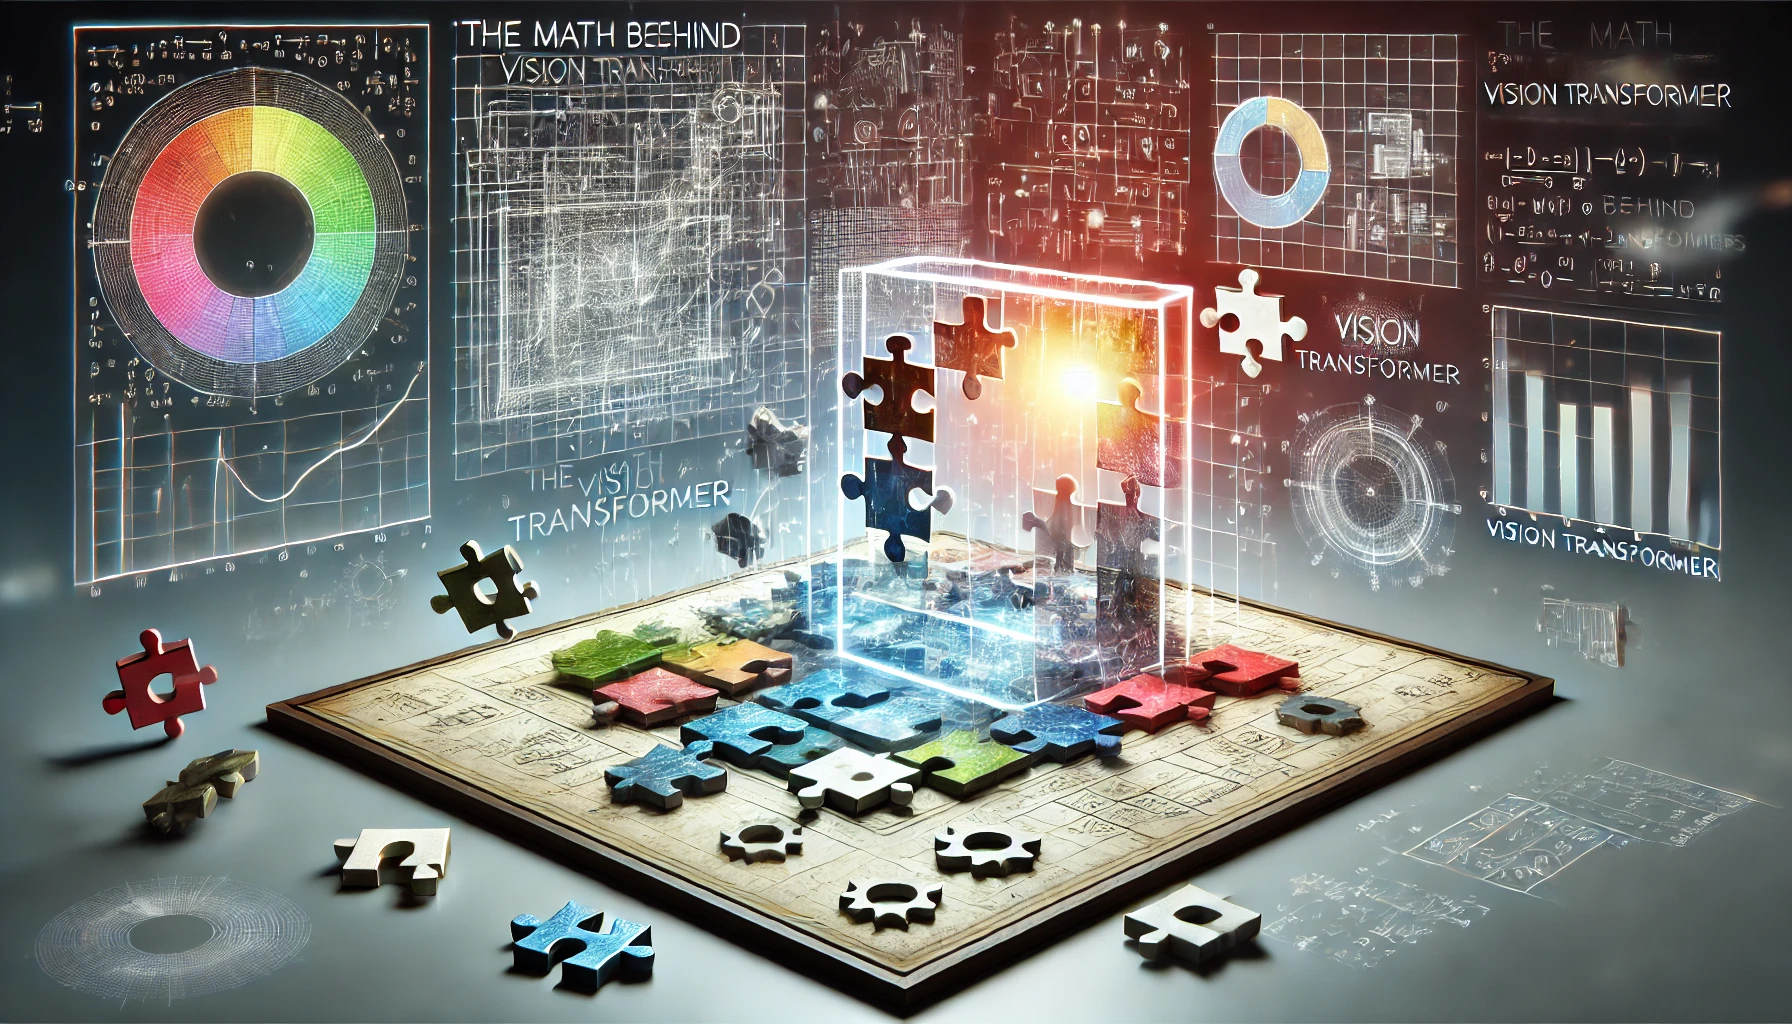

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification


# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
model.train()
for epoch in range(5):
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

# Save the model
torch.save(model.state_dict(), 'vit_cifar10.pth')

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


Files already downloaded and verified
Files already downloaded and verified


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps
Epoch 1, Loss: 0.35390268653507273
Epoch 2, Loss: 0.05825830528408918
Epoch 3, Loss: 0.04526726329509677
Epoch 4, Loss: 0.04385292936433452
Epoch 5, Loss: 0.043699070422773705
Test Accuracy: 98.33%


## Decomposing the Vision Transformer

In [2]:
image_data = torch.randn(64, 64, 3)

# Parameters
patch_size = 16  # Adjust this to your desired patch size
image_height, image_width, num_channels = image_data.shape

# Calculate the number of patches
num_patches = (image_height * image_width) // (patch_size * patch_size)

# Reshape the image data into a sequence of patches
patches = image_data.reshape(num_patches, patch_size, patch_size, num_channels)

# Flatten the patches into vectors
flattened_patches = patches.reshape(num_patches, -1)

print(f"Number of patches: {num_patches}")
print(f"Shape of flattened patches: {flattened_patches.shape}")

Number of patches: 16
Shape of flattened patches: torch.Size([16, 768])


In [3]:
def patch_embedding(patches, embedding_dim):
    """
    Performs patch embedding using a linear projection.

    Args:
        patches (np.ndarray): Flattened patches from the image.
        embedding_dim (int): The dimension of the embedding space.

    Returns:
        np.ndarray: Patch embeddings.
    """
    # Initialize a random projection matrix
    projection_matrix = np.random.randn(patches.shape[1], embedding_dim)
    return np.dot(patches, projection_matrix)

# Define the embedding dimension
embedding_dim = 512

# Perform patch embedding
patch_embeddings = patch_embedding(flattened_patches, embedding_dim)

print(f"Shape of patch embeddings: {patch_embeddings.shape}")

Shape of patch embeddings: (16, 512)


In [4]:
def positional_encoding(num_patches, embedding_dim):
    """
    Creates positional encoding vectors.

    Args:
        num_patches (int): The number of patches.
        embedding_dim (int): The dimension of the embedding space.

    Returns:
        np.ndarray: Positional encoding vectors.
    """
    # Create an array of positions
    positions = np.arange(num_patches)

    # Initialize a matrix to store the encodings
    positional_encodings = np.zeros((num_patches, embedding_dim))

    # Calculate sine and cosine encodings for different dimensions
    for i in range(embedding_dim):
        if i % 2 == 0:
            positional_encodings[:, i] = np.sin(positions / (10000 ** (2 * i / embedding_dim)))
        else:
            positional_encodings[:, i] = np.cos(positions / (10000 ** (2 * i / embedding_dim)))

    return positional_encodings

# Create positional encodings
pos_encodings = positional_encoding(num_patches, embedding_dim)

print(f"Shape of positional encodings: {pos_encodings.shape}")

Shape of positional encodings: (16, 512)


In [16]:
def softmax(x, axis=-1):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def multihead_attention(inputs, embedding_dim, num_heads):
    """
    Performs multi-head attention.

    Args:
        inputs (np.ndarray): Input embeddings.
        embedding_dim (int): The dimension of the embedding space.
        num_heads (int): The number of attention heads.

    Returns:
        np.ndarray: Attention output.
    """
    # Split the embedding dimension for each head
    head_dim = embedding_dim // num_heads

    # Initialize random matrices for query, key, and value
    Q = np.random.randn(inputs.shape[0], inputs.shape[1], num_heads, head_dim)

    K = np.random.randn(inputs.shape[0], inputs.shape[1], num_heads, head_dim)

    V = np.random.randn(inputs.shape[0], inputs.shape[1], num_heads, head_dim)

    # Calculate attention weights 
    attention_weights = np.einsum('bqhd,bkhd->bhqk', Q, K) / np.sqrt(head_dim)
    attention_weights = softmax(attention_weights, axis=-1)

    # Apply attention weights to value
    attention_output = np.einsum('bhqk,bkhd->bqhd', attention_weights, V)

    # Concatenate attention outputs from different heads
    attention_output = attention_output.reshape(inputs.shape[0], inputs.shape[1], -1)
    
    return attention_output

# Define the number of attention heads
num_heads = 8

# Perform multi-head attention
attention_output = multihead_attention(patch_embeddings, embedding_dim, num_heads)

print(f"Shape of attention output: {attention_output.shape}")

Shape of attention output: (16, 512, 512)


In [6]:
def mlp_block(inputs, mlp_dim):
    """
    Performs a simple MLP block.

    Args:
        inputs (np.ndarray): Input embeddings.
        mlp_dim (int): The dimension of the MLP hidden layer.

    Returns:
        np.ndarray: MLP output.
    """

    # First fully connected layer
    hidden_layer = np.dot(inputs, np.random.randn(inputs.shape[1], mlp_dim))
    # ReLU activation
    hidden_layer = np.maximum(0, hidden_layer)

    # Second fully connected layer
    mlp_output = np.dot(hidden_layer, np.random.randn(mlp_dim, inputs.shape[1]))
    return mlp_output

# Define the dimension of the MLP hidden layer
mlp_dim = 2048

# Perform MLP block
mlp_output = mlp_block(attention_output, mlp_dim)

print(f"Shape of MLP output: {mlp_output.shape}")

Shape of MLP output: (16, 512, 512)


In [7]:
def layer_normalization(inputs, epsilon=1e-6):
    """
    Performs layer normalization.

    Args:
        inputs (np.ndarray): Input embeddings.
        epsilon (float): Small value to prevent division by zero.

    Returns:
        np.ndarray: Normalized outputs.
    """

    # Calculate mean and variance along the last axis
    mean = np.mean(inputs, axis=-1, keepdims=True)
    variance = np.var(inputs, axis=-1, keepdims=True)

    # Normalize the inputs
    normalized_inputs = (inputs - mean) / np.sqrt(variance + epsilon)
    return normalized_inputs

# Perform layer normalization
normalized_output = layer_normalization(mlp_output)

print(f"Shape of normalized output: {normalized_output.shape}")

Shape of normalized output: (16, 512, 512)


In [19]:
def transformer_encoder_block(inputs, embedding_dim, num_heads, mlp_dim):
    """
    Performs a single Transformer encoder block.

    Args:
        inputs (np.ndarray): Input embeddings.
        embedding_dim (int): The dimension of the embedding space.
        num_heads (int): The number of attention heads.
        mlp_dim (int): The dimension of the MLP hidden layer.

    Returns:
        np.ndarray: Output embeddings.
    """

    # Multi-head Attention
    attention_output = multihead_attention(inputs, embedding_dim, num_heads)
    # Add residual connection
    attention_output = inputs.reshape(inputs.shape[0], inputs.shape[1], -1) + attention_output

    # Layer Normalization 
    attention_output = layer_normalization(attention_output)

    # MLP Block
    mlp_output = mlp_block(attention_output, mlp_dim)
    # Add residual connection
    mlp_output = attention_output + mlp_output

    # Layer Normalization 
    mlp_output = layer_normalization(mlp_output)

    return mlp_output

# Perform Transformer encoder block
transformer_output = transformer_encoder_block(patch_embeddings, embedding_dim, num_heads, mlp_dim)

print(f"Shape of Transformer output: {transformer_output.shape}")

Shape of Transformer output: (16, 512, 512)
